In [22]:
%load_ext autoreload
%autoreload 2

from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor
from sqlalchemy import event, create_engine, select
from sqlalchemy.orm import sessionmaker

from chemicalite_orm.molecules import SMILES_SAMPLE as mols


rdDepictor.SetPreferCoordGen(True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. 建表

In [23]:
from sqlalchemy import Integer, String
from sqlalchemy.orm import Mapped, declarative_base, mapped_column

from chemicalite_orm.search import enable_chem_search
from chemicalite_orm.types import Mol

DATABASE_URL = "sqlite:///chemicalite.db"

engine = create_engine(DATABASE_URL, echo=True)


@event.listens_for(engine, "connect")
def load_chemicalite(dbapi_conn, connection_record):
    dbapi_conn.enable_load_extension(True)
    dbapi_conn.load_extension("chemicalite")


Base = declarative_base()


@enable_chem_search(mol_col="molecule", id_col="id", fp_bits=2048, fp_radius=2)
class Compound(Base):  # type: ignore
    __tablename__ = "compound"

    id: Mapped[int] = mapped_column(Integer, primary_key=True)
    name: Mapped[str] = mapped_column(String, nullable=False)
    smiles: Mapped[str] = mapped_column(String, nullable=False)
    molecule: Mapped[Mol] = mapped_column(Mol, nullable=False)


Base.metadata.create_all(engine)       
SessionLocal = sessionmaker(bind=engine)

2025-05-02 18:43:04,873 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-02 18:43:04,875 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("compound")
2025-05-02 18:43:04,876 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-02 18:43:04,878 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("compound")
2025-05-02 18:43:04,879 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-02 18:43:04,881 INFO sqlalchemy.engine.Engine 
CREATE TABLE compound (
	id INTEGER NOT NULL, 
	name VARCHAR NOT NULL, 
	smiles VARCHAR NOT NULL, 
	molecule mol NOT NULL, 
	PRIMARY KEY (id)
)


2025-05-02 18:43:04,884 INFO sqlalchemy.engine.Engine [no key 0.00224s] ()
2025-05-02 18:43:04,909 INFO sqlalchemy.engine.Engine 
                CREATE VIRTUAL TABLE IF NOT EXISTS str_idx_compound
                USING rdtree(id, fp bits(2048))
            
2025-05-02 18:43:04,910 INFO sqlalchemy.engine.Engine [generated in 0.00123s] ()
2025-05-02 18:43:04,924 INFO sqlalchemy.engine.Engine 
                CREAT

## 2. 插入数据

In [16]:
with SessionLocal() as session:
    for i, smiles in enumerate(mols):
        compound = Compound(
            name=f"mol_{i}",
            smiles=smiles,
            molecule=Chem.MolFromSmiles(smiles),
        )
        session.add(compound)
    session.commit()

2025-05-02 18:39:42,749 INFO sqlalchemy.engine.Engine BEGIN (implicit)


2025-05-02 18:39:42,754 INFO sqlalchemy.engine.Engine INSERT INTO compound (name, smiles, molecule) VALUES (?, ?, mol_from_binary_mol(?))
2025-05-02 18:39:42,755 INFO sqlalchemy.engine.Engine [generated in 0.00185s] ('mol_0', 'NN=C(c1ccccc1)c1ccccc1', <memory at 0x7f574d100e80>)
2025-05-02 18:39:42,759 INFO sqlalchemy.engine.Engine INSERT INTO compound (name, smiles, molecule) VALUES (?, ?, mol_from_binary_mol(?))
2025-05-02 18:39:42,760 INFO sqlalchemy.engine.Engine [cached since 0.006878s ago] ('mol_1', 'COc1ccc(C=NO)cc1', <memory at 0x7f574d100d00>)
2025-05-02 18:39:42,762 INFO sqlalchemy.engine.Engine INSERT INTO compound (name, smiles, molecule) VALUES (?, ?, mol_from_binary_mol(?))
2025-05-02 18:39:42,763 INFO sqlalchemy.engine.Engine [cached since 0.01011s ago] ('mol_2', 'c1ccc(C(=NC(c2ccccc2)c2ccccc2)c2ccccc2)cc1', <memory at 0x7f574d100e80>)
2025-05-02 18:39:42,766 INFO sqlalchemy.engine.Engine INSERT INTO compound (name, smiles, molecule) VALUES (?, ?, mol_from_binary_mol(?))

## 3. 检索数据

2025-05-02 18:39:43,222 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-02 18:39:43,226 INFO sqlalchemy.engine.Engine SELECT compound.id, compound.name, compound.smiles, mol_to_binary_mol(compound.molecule) AS molecule 
FROM compound 
WHERE compound.name = ?
2025-05-02 18:39:43,228 INFO sqlalchemy.engine.Engine [generated in 0.00234s] ('mol_1',)


2025-05-02 18:39:43,233 INFO sqlalchemy.engine.Engine ROLLBACK


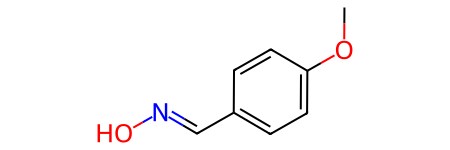

In [17]:
with SessionLocal() as session:
    stmt = select(Compound).where(Compound.name == "mol_1")
    result = session.execute(stmt).scalars().first()
    mol = result.molecule

mol

## 4. 子结构查询

2025-05-02 18:39:43,267 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-02 18:39:43,271 INFO sqlalchemy.engine.Engine SELECT compound.id, compound.name, compound.smiles, mol_to_binary_mol(compound.molecule) AS molecule 
FROM compound 
WHERE 
                compound.id IN (
                    SELECT id FROM str_idx_compound
                    WHERE id MATCH rdtree_subset(
                        mol_pattern_bfp(mol_from_smiles(?), 2048)
                    )
                )
            
2025-05-02 18:39:43,272 INFO sqlalchemy.engine.Engine [generated in 0.00165s] ('c1ccccc1',)
2025-05-02 18:39:43,278 INFO sqlalchemy.engine.Engine ROLLBACK


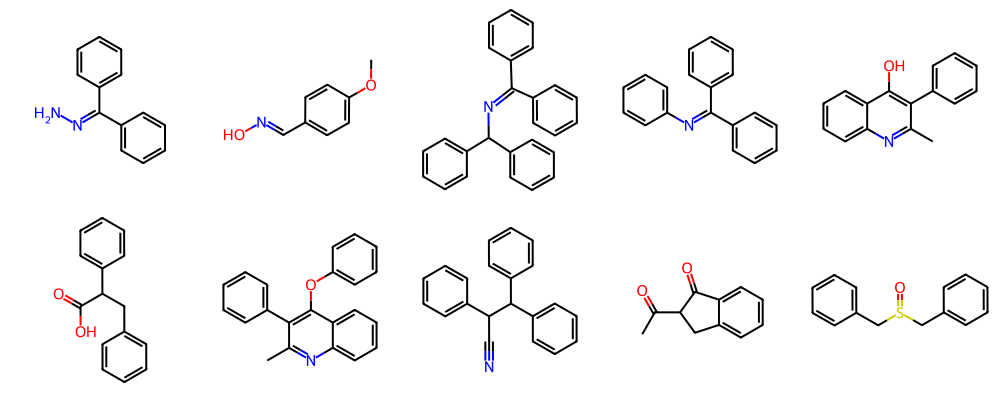

In [18]:
with SessionLocal() as session:
    stmt = select(Compound).where(Compound.has_substructure("c1ccccc1"))
    results = session.execute(stmt).scalars().all()

mols = [r.molecule for r in results[:10]]
Draw.MolsToGridImage(mols, molsPerRow=5)

## 5. 相似性查询

2025-05-02 18:39:56,515 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-02 18:39:56,517 INFO sqlalchemy.engine.Engine SELECT compound.id, compound.name, compound.smiles, mol_to_binary_mol(compound.molecule) AS molecule 
FROM compound 
WHERE 
                compound.id IN (
                    SELECT id FROM sim_idx_compound
                    WHERE bfp_tanimoto(
                        fp,
                        mol_morgan_bfp(mol_from_smiles(?), 2, 2048)
                    ) >= ?
                )
            
2025-05-02 18:39:56,518 INFO sqlalchemy.engine.Engine [cached since 13.17s ago] ('c1ccnnc1', 0.1)
2025-05-02 18:39:56,521 INFO sqlalchemy.engine.Engine ROLLBACK


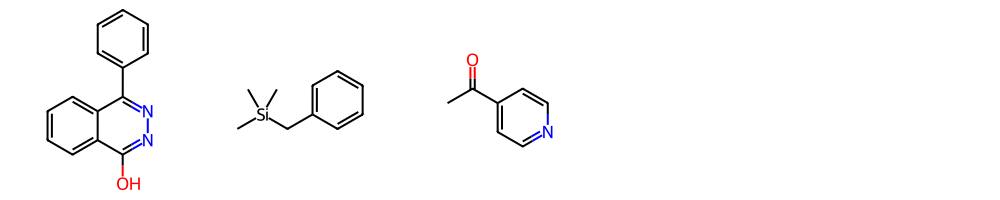

In [21]:
with SessionLocal() as session:
    stmt = select(Compound).where(Compound.similarity_to("c1ccnnc1", 0.1))
    results = session.execute(stmt).scalars().all()

mols = [r.molecule for r in results[:10]]
Draw.MolsToGridImage(mols, molsPerRow=5)
